In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:43: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:45: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:47: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:47: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:50: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

In [7]:
df=pd.DataFrame()
d_map=sector_map(amihud)
for sect in d_map.keys():
    df[sect]=amihud[d_map[sect]].median(axis=1)

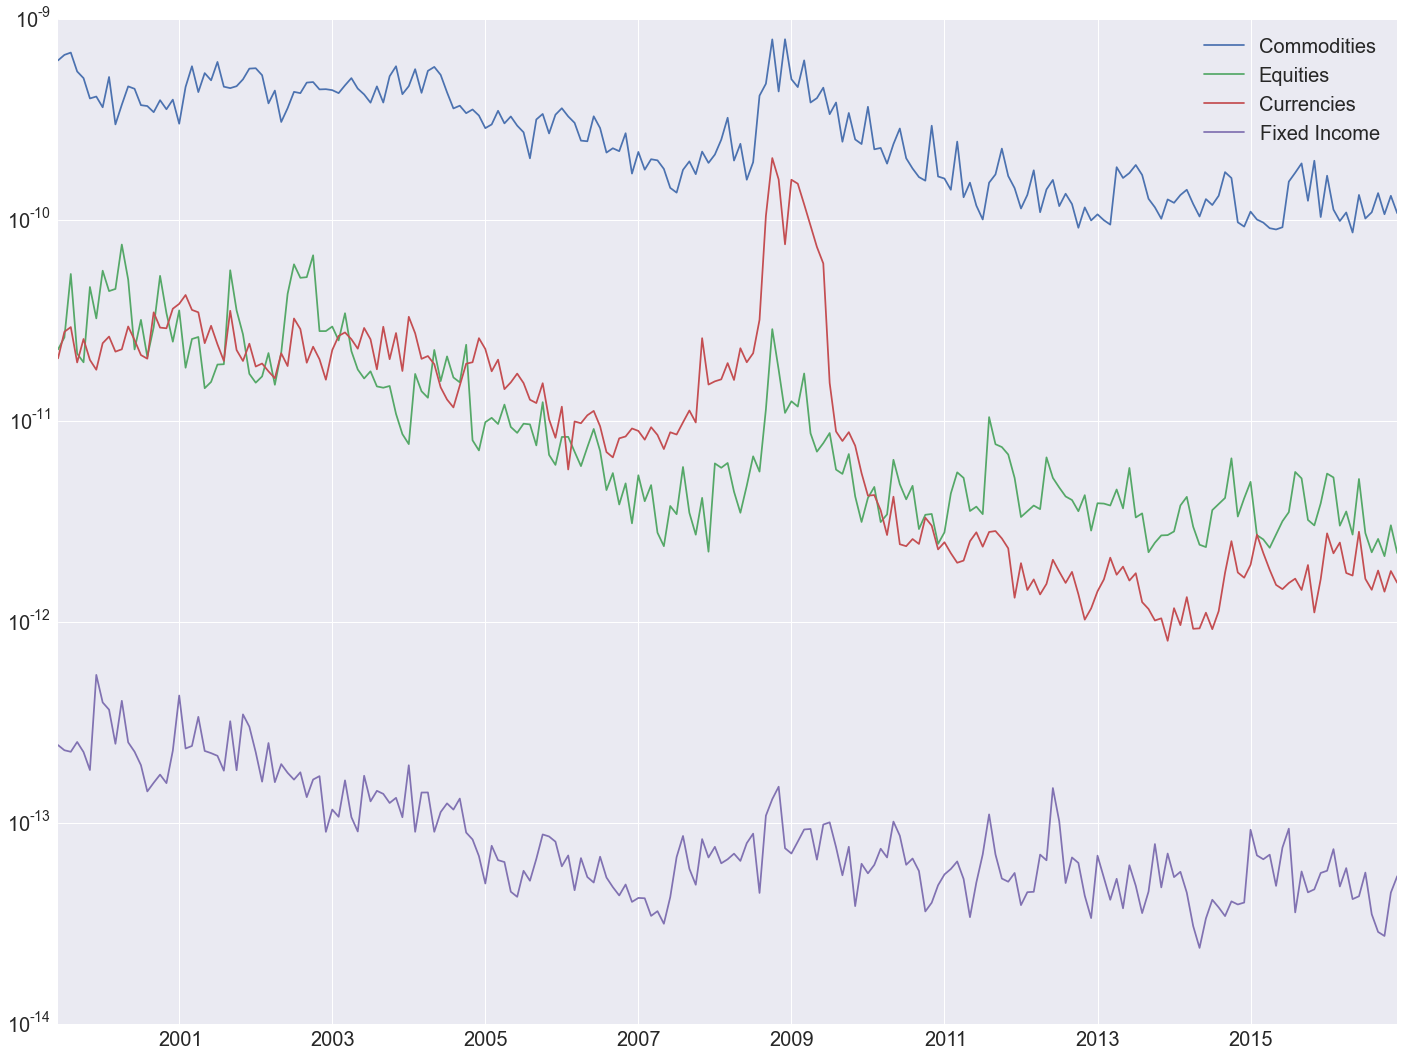

In [8]:
df.dropna().plot(logy=True)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


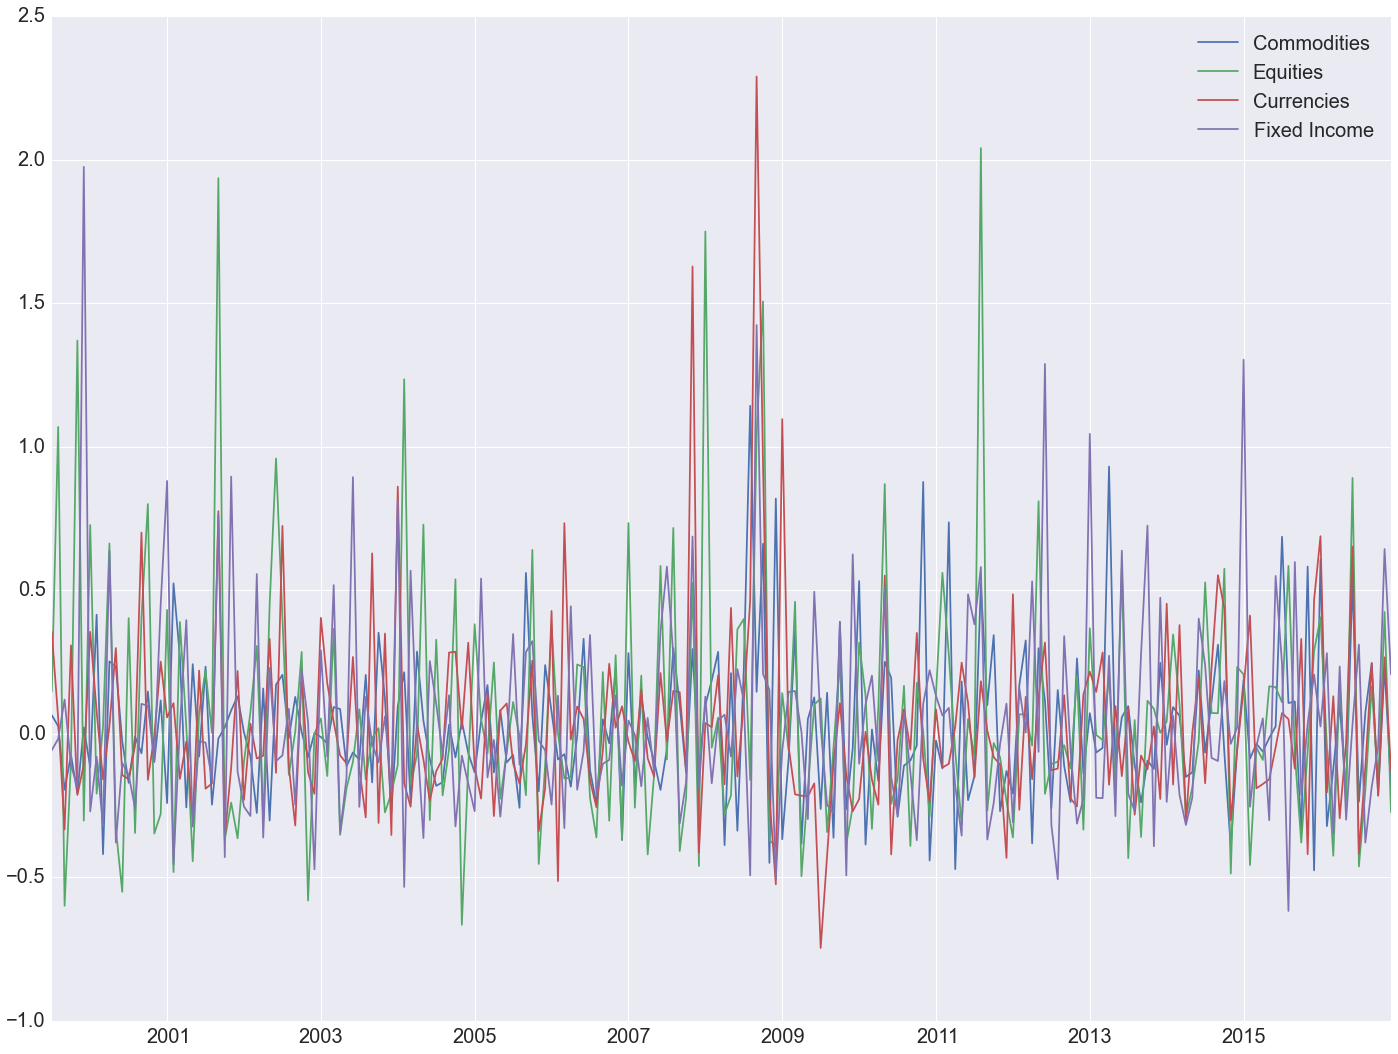

In [9]:
df.resample(rule='m',how='last').pct_change().dropna().plot()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


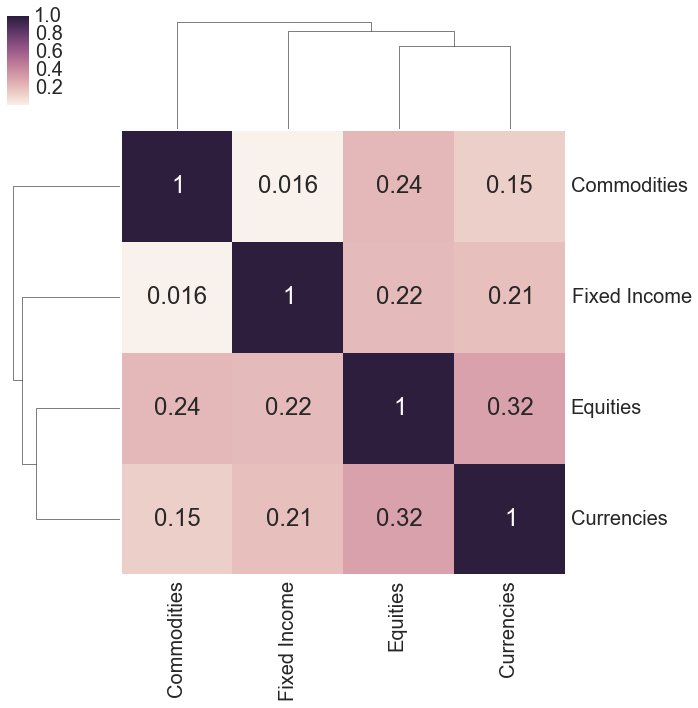

In [10]:
# Monthly resampling correlation
sns.clustermap(df.resample(rule='m',how='last').pct_change().corr(),annot=True)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


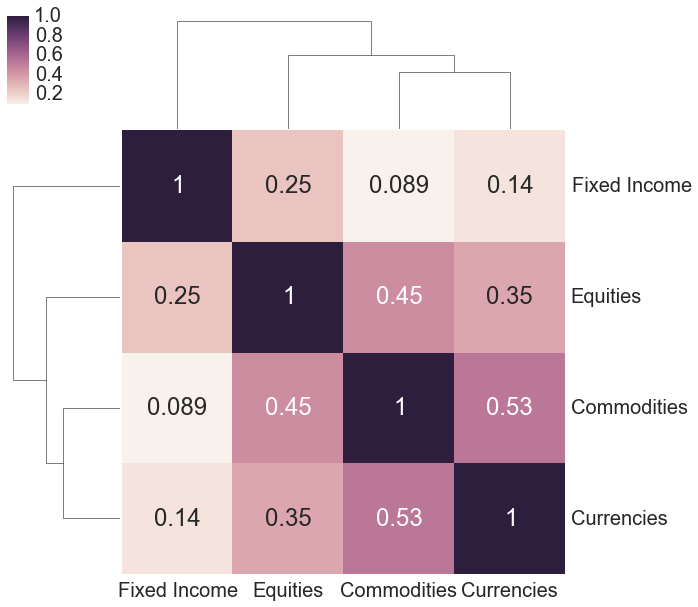

In [11]:
# Quarterly resampling correlation
sns.clustermap(df.resample(rule='q',how='last').pct_change().corr(),annot=True)

In [12]:
mp =load_maps()
s = pd.Series()
for sect in mp.Sector.unique():
    s[sect]= mp[mp.Sector==sect].Sector.count()

In [13]:
res=pd.DataFrame()
res['Mean']=df.mean()*1e13
res['Standard Deviation']=df.std()*1e13
res['Skew']=df.skew()
res['Kurtosis']=df.kurt()
res['Number of Markets']=s

In [14]:
print res.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &         Mean &  Standard Deviation &  Skew &  Kurtosis &  Number of Markets \\
\midrule
Commodities  &  2892.796273 &         1606.473446 &   0.0 &       0.0 &                 76 \\
Equities     &   124.833453 &          138.943591 &   0.0 &       0.0 &                 29 \\
Currencies   &   172.022897 &          271.236341 &   0.0 &       0.0 &                  8 \\
Fixed Income &     1.032817 &            0.836522 &   0.0 &       0.0 &                 32 \\
\bottomrule
\end{tabular}



In [15]:
res.to_csv('amihud.csv')

In [16]:
df.dropna().to_csv('amihud_ts.csv')

In [17]:
residual=pd.DataFrame()
for sec in df.columns:
    shif=df[sec].shift(2).dropna()
    res=sm.OLS(shif,df[sec].ix[shif.index]).fit()
    print res.params
    residual[sec]=res.resid


Commodities    0.98584
dtype: float64
Equities    0.868642
dtype: float64
Currencies    0.817403
dtype: float64
Fixed Income    0.931949
dtype: float64


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


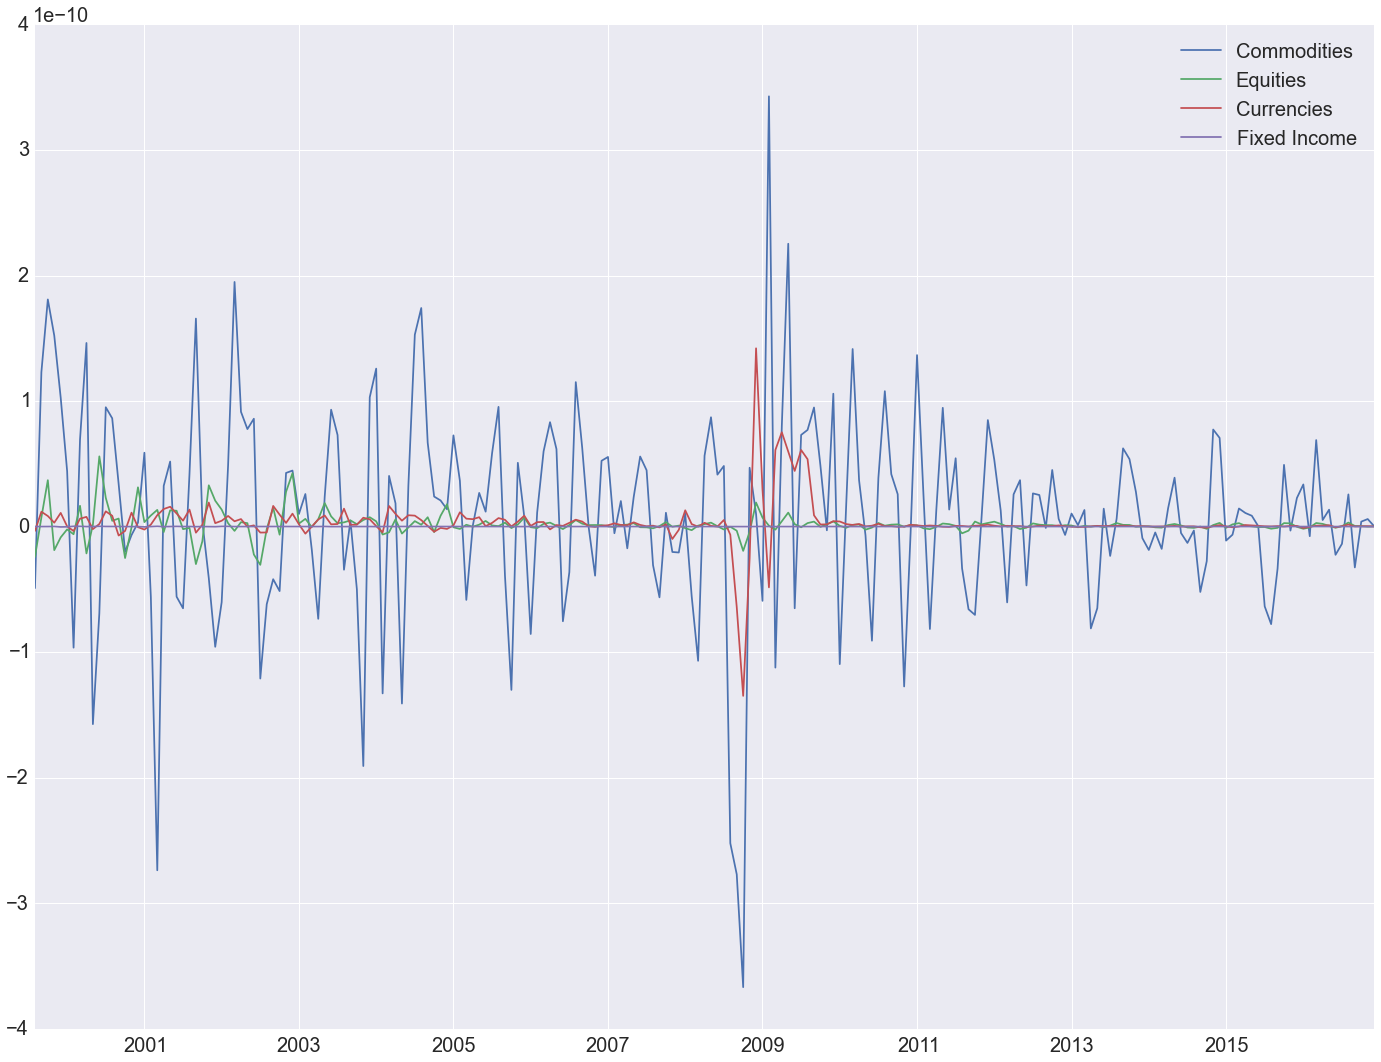

In [18]:
residual.plot()

In [19]:
residual.corr()

Commodities  Equities  Currencies  Fixed Income
Commodities      1.000000  0.076197    0.242009     -0.133141
Equities         0.076197  1.000000    0.251517      0.277303
Currencies       0.242009  0.251517    1.000000      0.139351
Fixed Income    -0.133141  0.277303    0.139351      1.000000

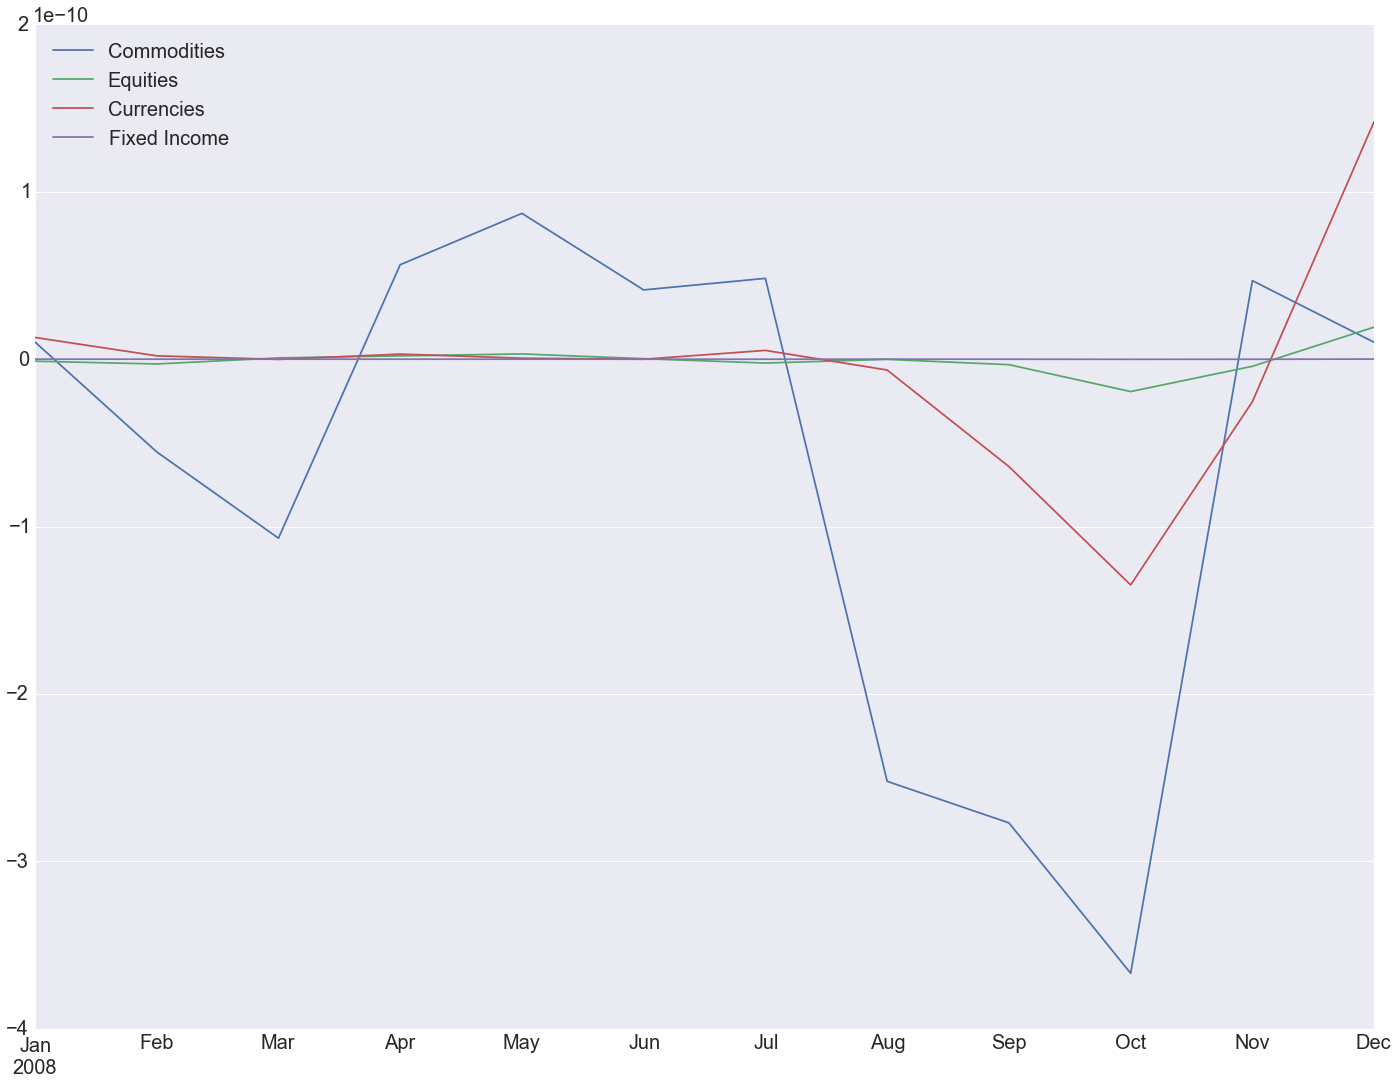

In [20]:
residual['2008'].plot()

# Standardize factors by rolling zscore
I use expanding window as per Korajczyk and Sadka 2008



In [17]:
zscore_markets=calc_zscore_expanding_window(amihud.dropna(how='all'))
zscore_sector=pd.DataFrame()
d_map=sector_map(zscore_markets)
for sect in d_map.keys():
    zscore_sector[sect]=zscore_markets[d_map[sect]].mean(axis=1)

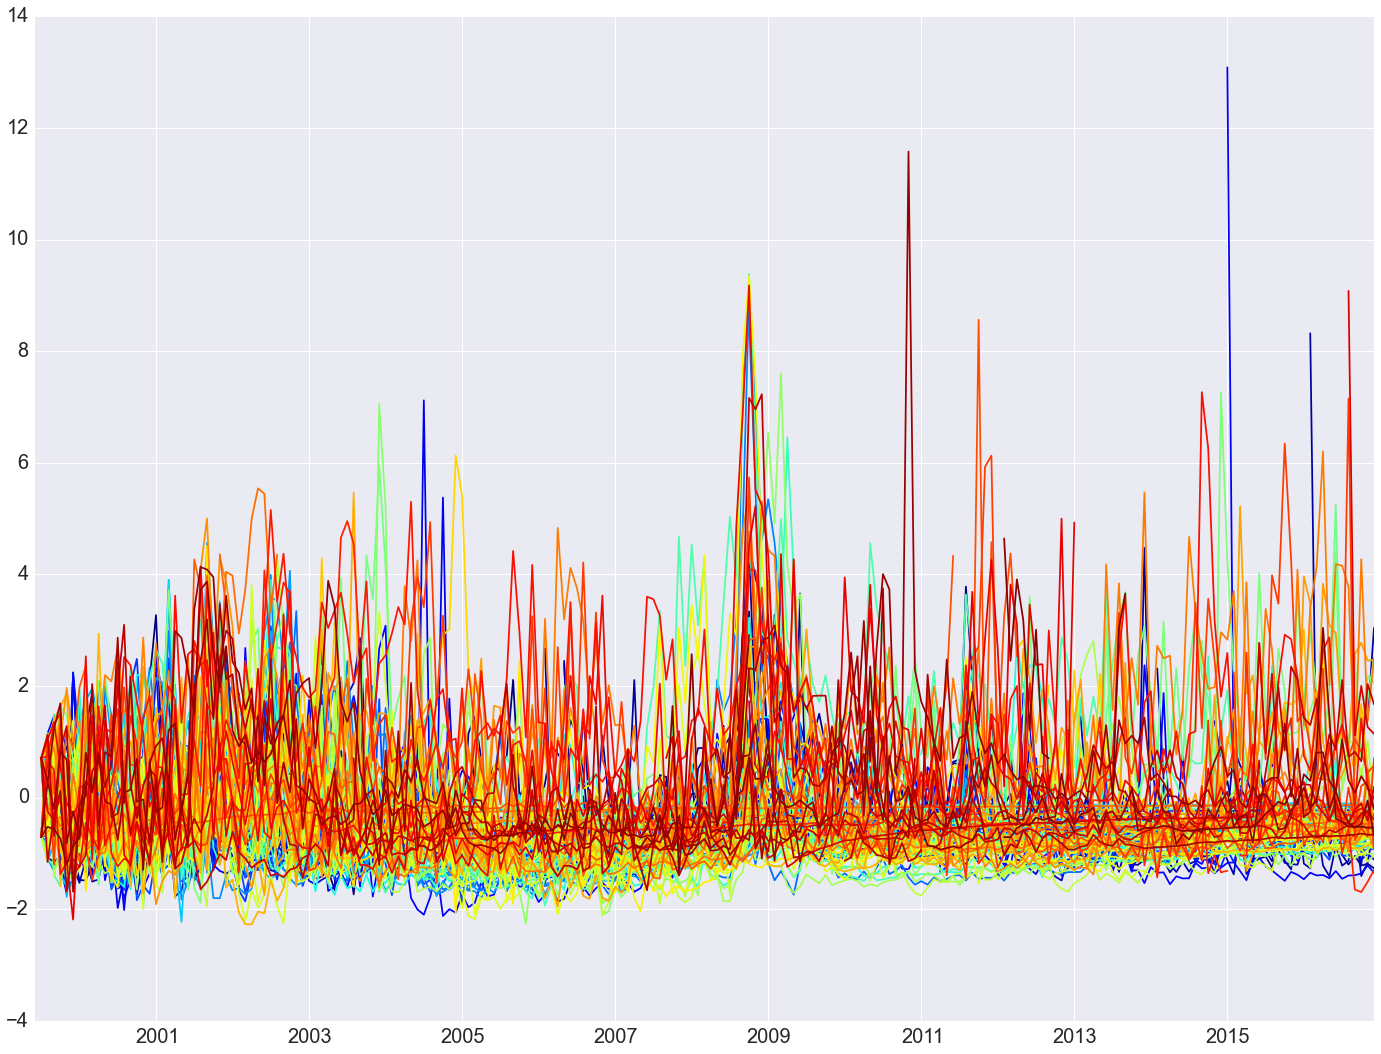

In [18]:
zscore_markets.plot(colormap='jet',legend=False)

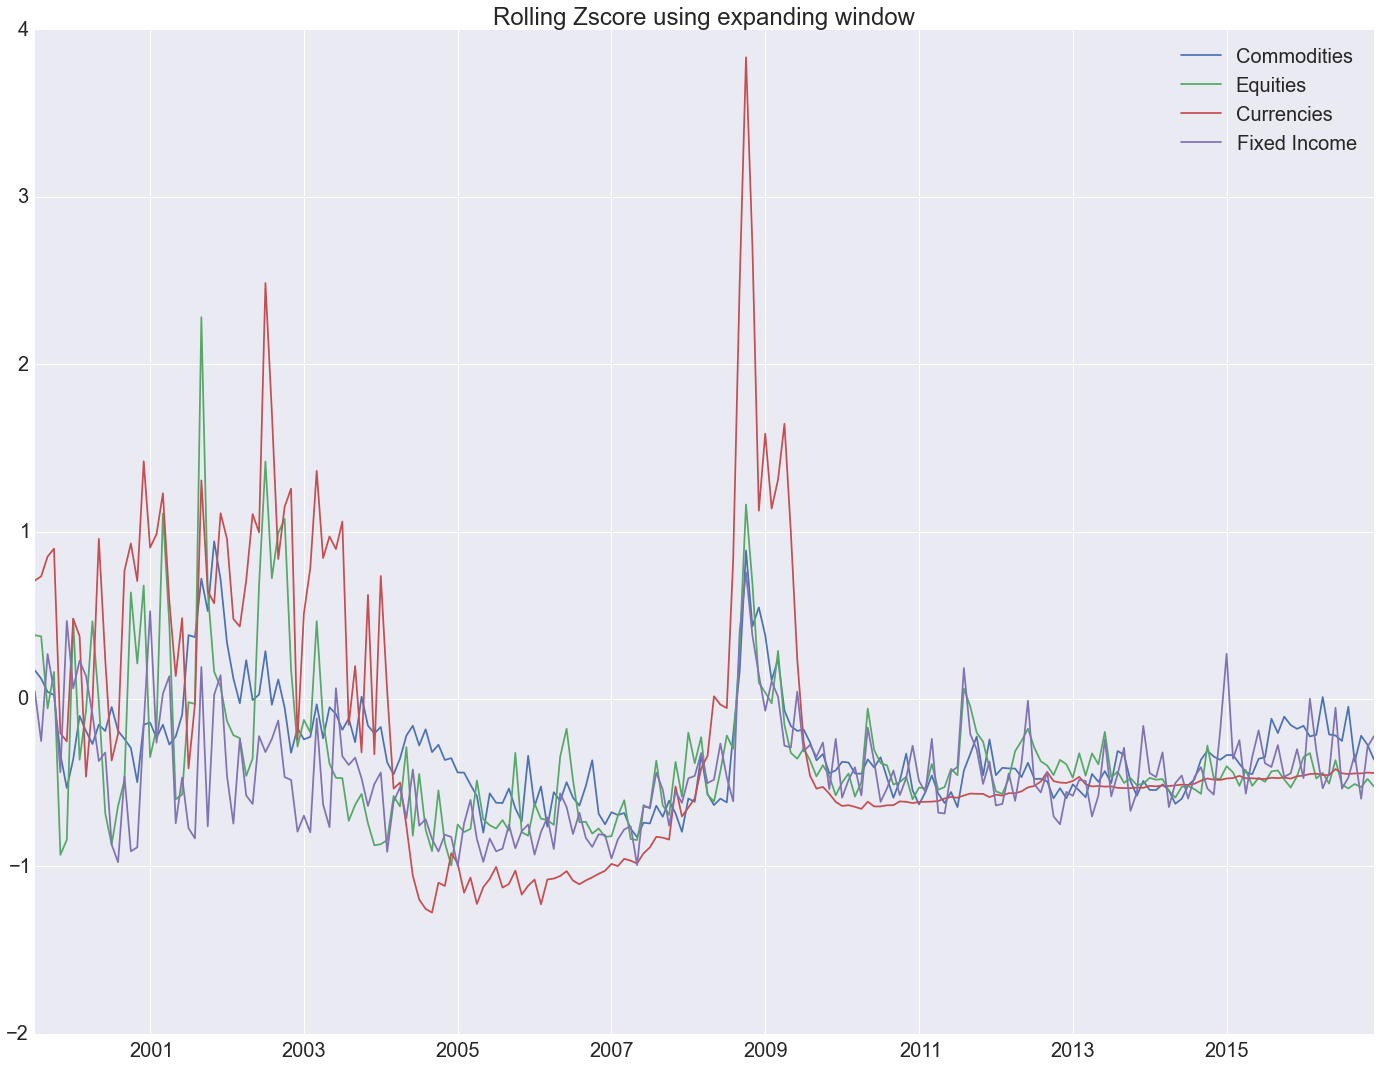

In [11]:
zscore_sector.dropna().plot(title='Rolling Zscore using expanding window')

In [12]:
zscore_markets=calc_zscore_ew(amihud.dropna(how='all'))
zscore_sector=pd.DataFrame()
d_map=sector_map(zscore_markets)
for sect in d_map.keys():
    zscore_sector[sect]=zscore_markets[d_map[sect]].mean(axis=1)

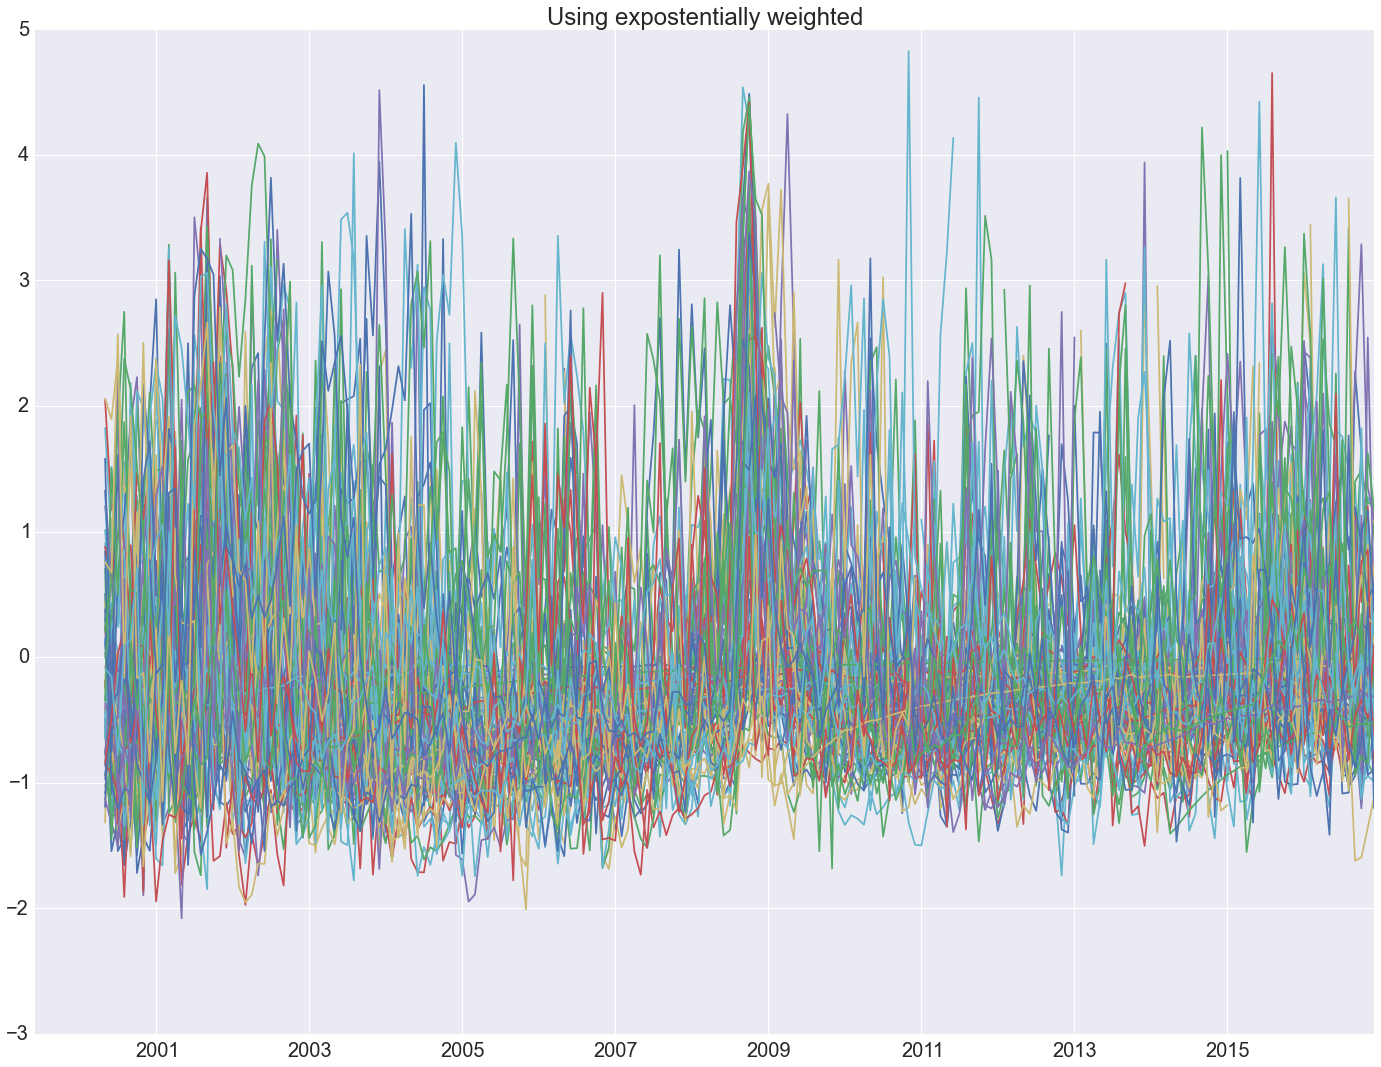

In [16]:
zscore_markets.plot(title='Using expostentially weighted',legend=False)

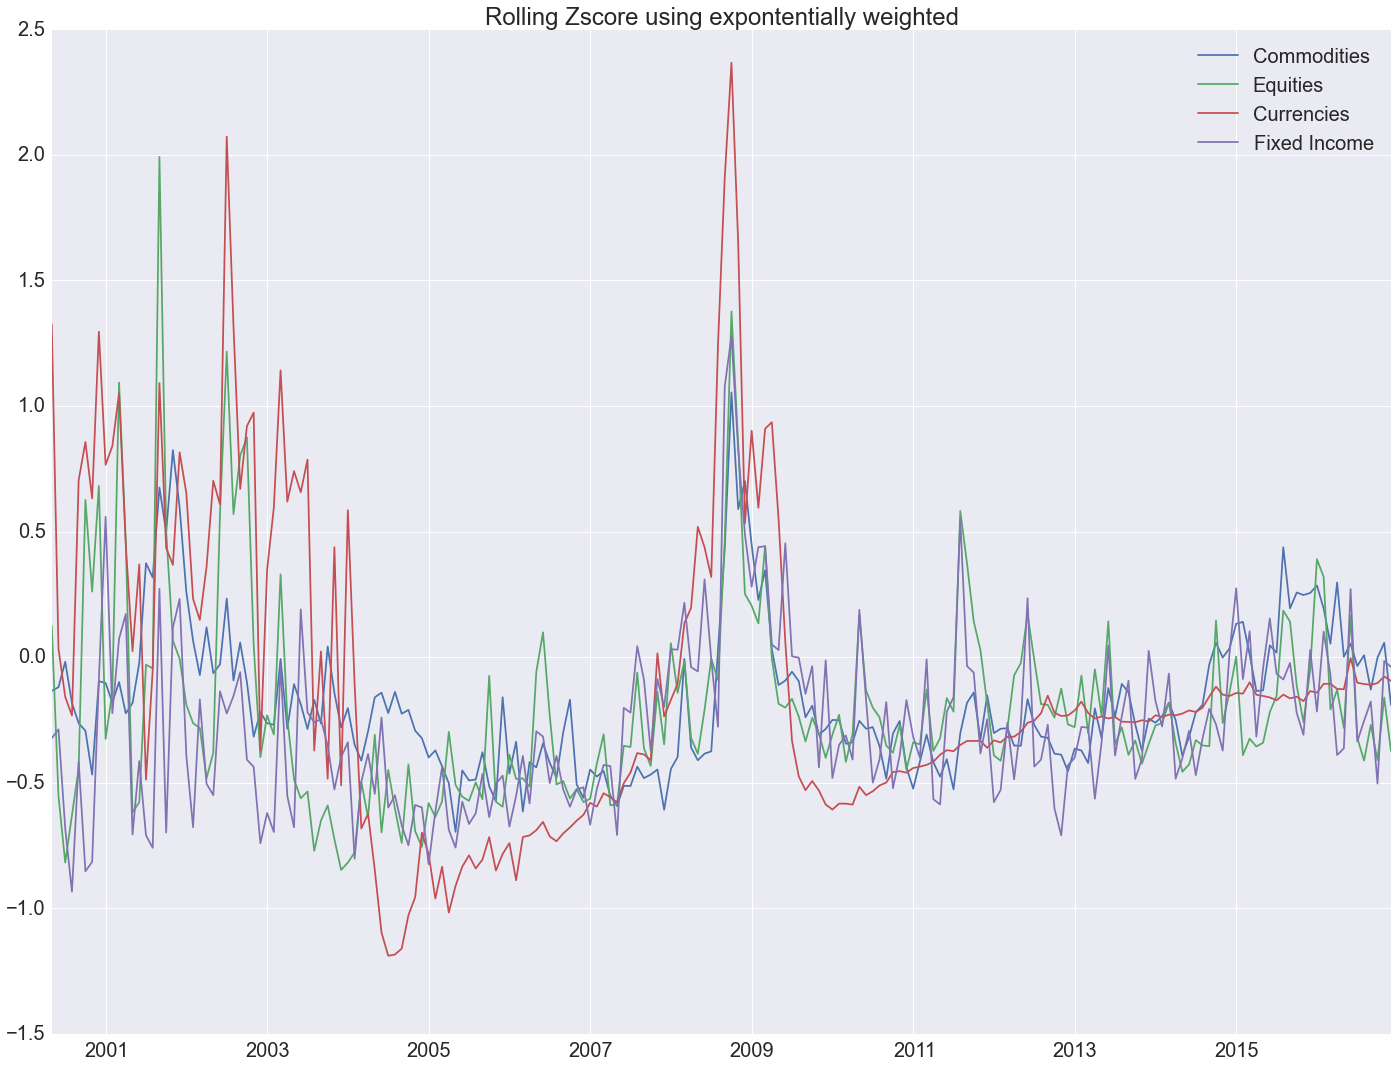

In [14]:
zscore_sector.dropna().plot(title='Rolling Zscore using expontentially weighted')

# Checking how much autocorrelation there is even in the zscore model

In [19]:
residual=pd.DataFrame()
for sec in zscore_sector.columns:
    shif=zscore_sector[sec].shift(2).dropna()
    res=sm.OLS(shif,zscore_sector[sec].ix[shif.index]).fit()
    print res.params
    residual[sec]=res.resid

Commodities    0.896964
dtype: float64
Equities    0.648221
dtype: float64
Currencies    0.792443
dtype: float64
Fixed Income    0.812701
dtype: float64


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


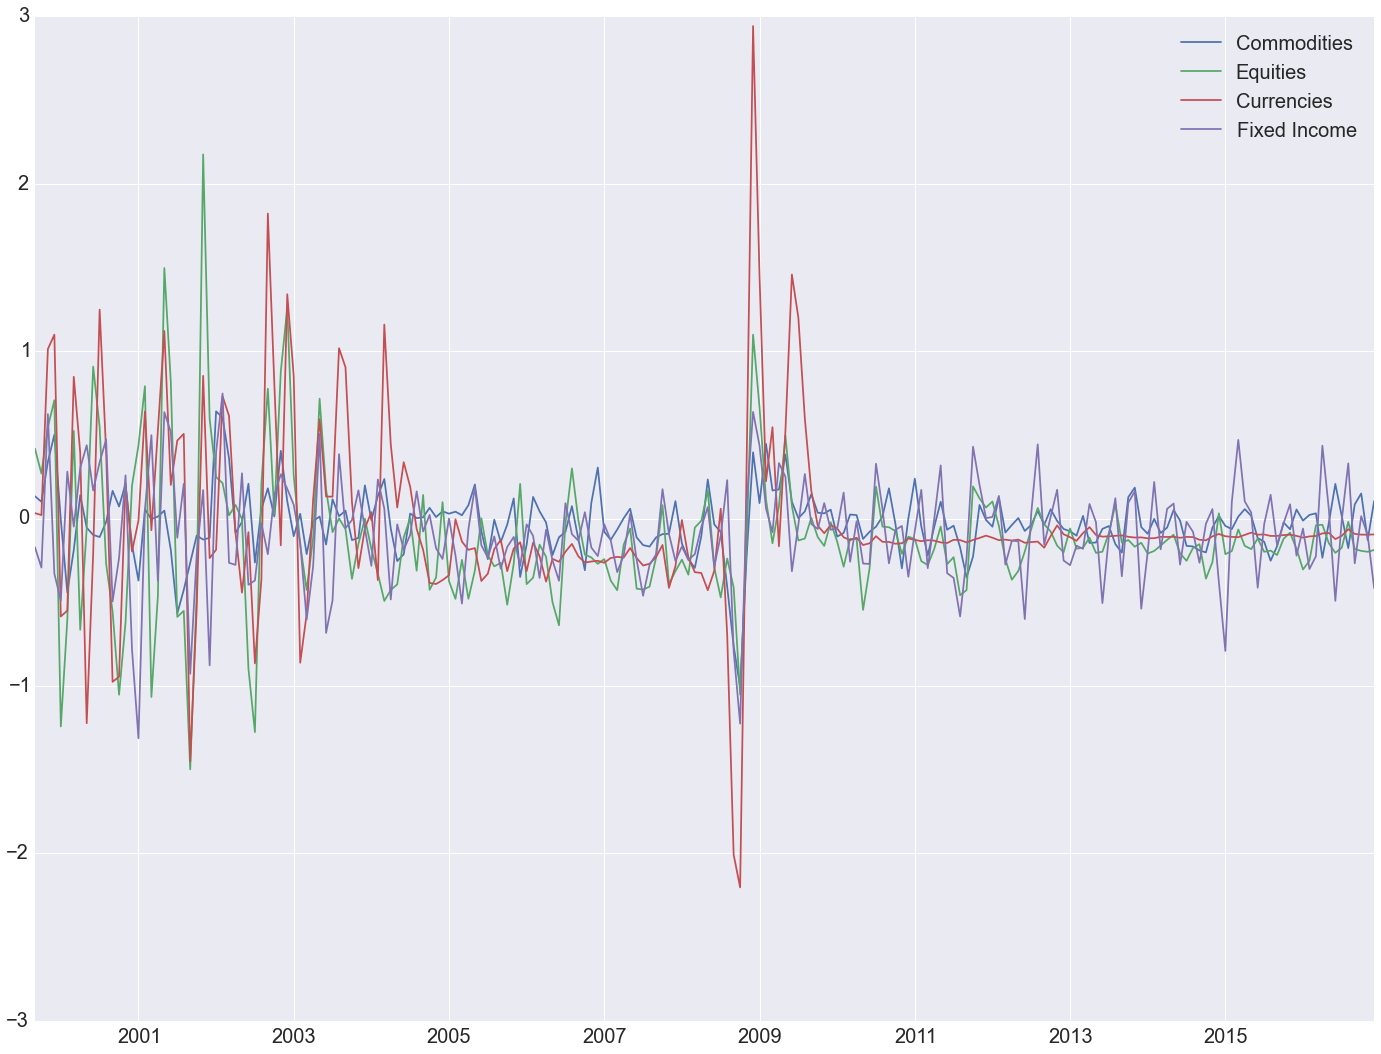

In [20]:
residual.plot()